In [1]:
import sys
import json
import os
from pprint import pprint
from subprocess import call
import subprocess
from subprocess import call, Popen, PIPE, check_output, STDOUT, CalledProcessError
import platform
import time
import shutil
from collections import OrderedDict
import datetime
from kafka import KafkaConsumer, KafkaProducer, TopicPartition

import matplotlib.pyplot as plt
import pandas as pd

<h1>Killing Leader Node</h1>

In [2]:
# Generate dummy Data
def generate_dummy_data(broker_port, topic, data_source):
        call(f"../deploy/kafka/bin/kafka-console-producer.sh < {data_source} --topic {topic} --broker-list localhost:{broker_port}", shell=True)

In [3]:
def plot(results, title, xlabel, ylabel):
    results['index1'] = results.index
    plt.scatter(results['index1'], results['time_taken'])
    plt.plot(results['index1'], results['time_taken'])
    max_val = results['time_taken'].max()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

<h2>Regular Kafka</h2>

<h3>Killing a single leader node (ticktime=2000)</h3>

In [3]:
def get_node_with_most_partitions(topic):
    proc1 = subprocess.Popen(['../deploy/kafka/bin/kafka-topics.sh', '--describe', '--zookeeper', 'localhost:2181', '--topic', topic], stdout=subprocess.PIPE)

    out, err = proc1.communicate()
    values = out.decode("utf-8").split(" ")
    leader_counts = dict()
    for i, val in enumerate(values):
        if 'Leader' in val:
            leader_node = values[i+1].split('\t')[0]
            if leader_node not in leader_counts:
                leader_counts[leader_node] = 0
            leader_counts[leader_node] += 1
    max_val = max(leader_counts, key=lambda k: leader_counts[k])
    print(f"{leader_counts}" )
    return int(max_val)

In [4]:
def get_node_pid(node):
    proc1 = subprocess.Popen(['ps', 'aux'], stdout=subprocess.PIPE)
    proc2 = subprocess.Popen(['grep', f'output/2181_cluster/broker_2181_{node}.properties'], stdin=proc1.stdout,
                             stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    proc3 = subprocess.Popen(['awk', '{print $2}'], stdin=proc2.stdout,
                             stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    proc1.stdout.close()
    proc2.stdout.close()
    out, err = proc3.communicate()
    values = out.decode("utf-8").split(" ")[0]
    return int(values.split('\n')[0])
    

In [8]:
def run_consumer_kill(topicName, pid, port):
    consumer = KafkaConsumer(bootstrap_servers=f'localhost:{port}',
                                 auto_offset_reset='earliest',
                                 consumer_timeout_ms=10000000)
    consumer.subscribe([topicName])
    data_frame = pd.DataFrame()
       
    i = 0
    start = time.time()
    for message in consumer:
        end = time.time()
        data_frame.loc[i,'time_taken'] = end - start
        if i == 50:
            print("Killing node...")
            call(f"kill -9 {pid}", shell=True)
        elif i == 100:
            break
        i += 1
        start = time.time()
        
    return data_frame

In [6]:
def test_kill_one(topic, destTopic='', fallback=-1):
    node_to_port = OrderedDict([(0, 9092,), (10, 9095), (11, 9096)])
    # Want to test worst case scenario -> so get node that is assigned the most partitions
    max_leader_node = get_node_with_most_partitions(topic)
    
    # Get the PID of the node
    pid = get_node_pid(max_leader_node)

    # If the pid is not the correct port, then calling the same function will return a different number
    if pid != get_node_pid(max_leader_node):
        print("ERROR: Failed to get PID")
    else:
        if fallback == -1:
            # Get the port of any node other than the one we are killing
            fallback = list(node_to_port.items())[(list(node_to_port.keys()).index(max_leader_node) + 1) % len(list(node_to_port.keys()))][1]
        
        print(f"killing broker id {max_leader_node} | {pid}")
        print(f"Falling back to port {fallback} after killing node")
        
        # Spin up the consumer
        if len(destTopic) != 0:
            topic = destTopic
        results_kill_one = run_consumer_kill(topic, pid, fallback)
            
        
        return results_kill_one

In [ ]:
results_kill_one_10 = test_kill_one('testTopic10')

In [ ]:
results_kill_one_10

In [25]:
results_kill_one_100 = test_kill_one('testTopic100')

{'11': 34, '0': 33, '10': 33}
killing broker id 11 | 6715
using port 9092 to produce


In [26]:
print(results_kill_one_100.max())

time_taken    17.356029
dtype: float64


In [33]:
results_kill_one_1000 = test_kill_one('testTopic1000')

{'none': 1, '11': 333, '0': 333, '10': 333}
killing broker id 11 | 31432
using port 9092 to produce


In [35]:
results_kill_one_1000.max()

time_taken      4.997806
index         100.000000
dtype: float64

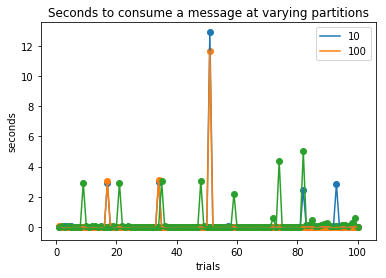

In [34]:
# plot(results.loc[1:], 'Seconds to consume a message (1 Leader Node Killed)', 'Trial', 'Seconds')

results_kill_one_10 = results_kill_one_10.loc[1:]
results_kill_one_100 = results_kill_one_100.loc[1:]
results_kill_one_1000 = results_kill_one_1000.loc[1:]
results_kill_one_10['index'] = results_kill_one_10.index
results_kill_one_100['index'] = results_kill_one_100.index
results_kill_one_1000['index'] = results_kill_one_1000.index

plt.scatter(results_kill_one_10['index'], results_kill_one_10['time_taken'])
plt.plot(results_kill_one_10['index'], results_kill_one_10['time_taken'])

plt.scatter(results_kill_one_100['index'], results_kill_one_100['time_taken'])
plt.plot(results_kill_one_100['index'], results_kill_one_100['time_taken'])

plt.scatter(results_kill_one_1000['index'], results_kill_one_1000['time_taken'])
plt.plot(results_kill_one_1000['index'], results_kill_one_1000['time_taken'])

plt.legend(['10', '100'])

# max_val = results['time_taken'].max()
plt.title('Seconds to consume a message at varying partitions')
plt.xlabel('trials')
plt.ylabel('seconds')
plt.show()

<p>There does <strong>NOT</strong> seem to be a relationship between consumer inactivty and partition size <p>

<h3>Killing a single leader node (ticktime=500)</h3>

In [37]:
results_kill_one_10_500 = test_kill_one('testTopic10')

{'11': 10}
killing broker id 11 | 20140
using port 9092 to produce


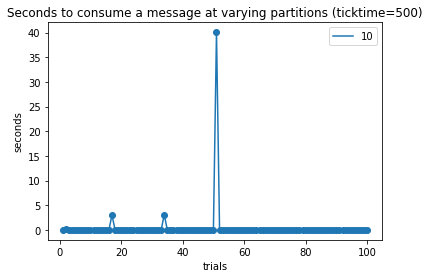

In [46]:
results_kill_one_10_500 = results_kill_one_10_500.loc[1:]

results_kill_one_10_500['index'] = results_kill_one_10_500.index

plt.scatter(results_kill_one_10_500['index'], results_kill_one_10_500['time_taken'])
plt.plot(results_kill_one_10_500['index'], results_kill_one_10_500['time_taken'])

plt.legend(['10'])

# max_val = results['time_taken'].max()
plt.title('Seconds to consume a message at varying partitions (ticktime=500)')
plt.xlabel('trials')
plt.ylabel('seconds')
plt.show()

<p>Changing tick time does <strong>NOT</strong> affect duration of consumer inactivity</p>


In [43]:
results_kill_one_10_50 = test_kill_one('testTopic10')

{'11': 4, '0': 3, '10': 3}
killing broker id 11 | 27264
using port 9092 to produce


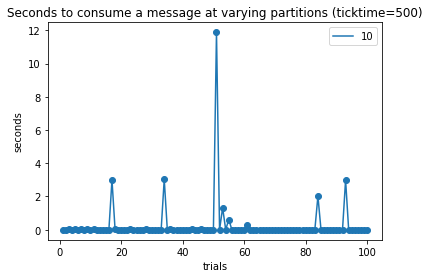

In [45]:
results_kill_one_10_50 = results_kill_one_10_50.loc[1:]

results_kill_one_10_50['index'] = results_kill_one_10_50.index

plt.scatter(results_kill_one_10_50['index'], results_kill_one_10_50['time_taken'])
plt.plot(results_kill_one_10_50['index'], results_kill_one_10_50['time_taken'])

plt.legend(['10'])

# max_val = results['time_taken'].max()
plt.title('Seconds to consume a message at varying partitions (ticktime=50)')
plt.xlabel('trials')
plt.ylabel('seconds')
plt.show()

In [48]:
results_kill_one_10_5000 = test_kill_one('testTopic10')

{'11': 4, '0': 3, '10': 3}
killing broker id 11 | 1777
using port 9092 to produce


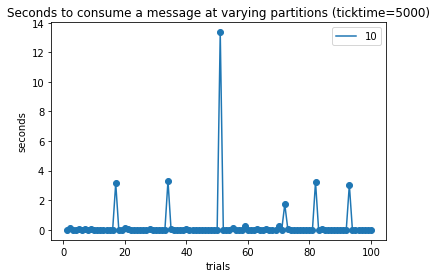

In [50]:
results_kill_one_10_5000 = results_kill_one_10_5000.loc[1:]

results_kill_one_10_5000['index'] = results_kill_one_10_5000.index

plt.scatter(results_kill_one_10_5000['index'], results_kill_one_10_5000['time_taken'])
plt.plot(results_kill_one_10_5000['index'], results_kill_one_10_5000['time_taken'])

plt.legend(['10'])

# max_val = results['time_taken'].max()
plt.title('Seconds to consume a message at varying partitions (ticktime=5000)')
plt.xlabel('trials')
plt.ylabel('seconds')
plt.show()

<h1>Dynamically adding Partitions</h1>

In [63]:
def run_consumer_add_partitions(topicName, partitions, port):
    consumer = KafkaConsumer(bootstrap_servers=f'localhost:{port}',
                                 auto_offset_reset='earliest',
                                 consumer_timeout_ms=10000000)
    consumer.subscribe([topicName])
    data_frame = pd.DataFrame()
       
    i = 0
    start = time.time()
    for message in consumer:
        end = time.time()
        data_frame.loc[i,'time_taken'] = end - start
        if i == 50:
            # add partitions
            call(f"../deploy/kafka/bin/kafka-topics.sh --zookeeper localhost:2181 --alter --topic {topicName} --partitions {partitions}", shell=True)
        elif i == 100:
            break
        i += 1
        start = time.time()
        
    return data_frame

In [64]:
def test_add_partitions(topic, partitions, port):
    results = run_consumer_add_partitions(topic, partitions, port)
    return results

<h3>Adding a single partition</h3>

In [65]:
results_add_one_partition = test_add_partitions('testTopic1000', 1001, 9092)

In [69]:
results_add_ten_partitions = test_add_partitions('testTopic1000', 1010, 9092)

In [71]:
results_add_thousand_partitions = test_add_partitions('testTopic1000', 1100, 9092)

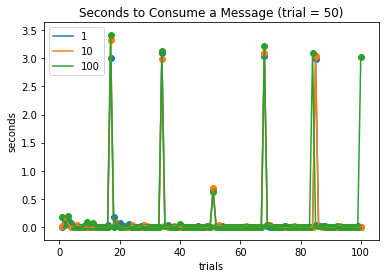

In [73]:
results_add_one_partition = results_add_one_partition.loc[1:]
results_add_ten_partitions = results_add_ten_partitions.loc[1:]
results_add_thousand_partitions = results_add_thousand_partitions.loc[1:]

results_add_one_partition['index'] = results_add_one_partition.index
results_add_ten_partitions['index'] = results_add_ten_partitions.index
results_add_thousand_partitions['index'] = results_add_thousand_partitions.index

plt.scatter(results_add_one_partition['index'], results_add_one_partition['time_taken'])
plt.plot(results_add_one_partition['index'], results_add_one_partition['time_taken'])

plt.scatter(results_add_ten_partitions['index'], results_add_ten_partitions['time_taken'])
plt.plot(results_add_ten_partitions['index'], results_add_ten_partitions['time_taken'])

plt.scatter(results_add_thousand_partitions['index'], results_add_thousand_partitions['time_taken'])
plt.plot(results_add_thousand_partitions['index'], results_add_thousand_partitions['time_taken'])

plt.legend(['1', '10','100'])

# max_val = results['time_taken'].max()
plt.title('Seconds to Consume a Message (trial = 50)')
plt.xlabel('trials')
plt.ylabel('seconds')
plt.show()

<p>Adding partitions dynamically does not appear to cause any issues and consumer inactivity doesn't seem to be proportional to the number of partitions we are adding</p>

<h1>Using uReplicator</h1>

<h2>Measuring latency between inter cluster replication</h2>

In [ ]:
u_results_kill_one_1000 = test_kill_one('testTopic1000', destTopic='testTopic1000_1', fallback=9094)

In [15]:
u_results_kill_one_1000.describe()

,time_taken,index
count,100.000000,100.000000
mean,0.281303,50.500000
std,1.277005,29.011492
min,0.000018,1.000000
25%,0.000020,25.750000
50%,0.002590,50.500000
75%,0.070793,75.250000
max,11.541194,100.000000


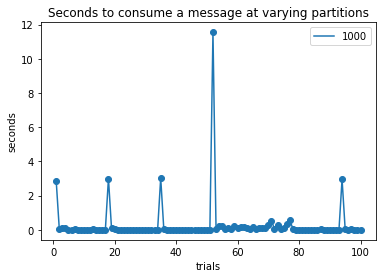

In [13]:
u_results_kill_one_1000 = u_results_kill_one_1000.loc[1:]

u_results_kill_one_1000['index'] = u_results_kill_one_1000.index

plt.scatter(u_results_kill_one_1000['index'], u_results_kill_one_1000['time_taken'])
plt.plot(u_results_kill_one_1000['index'], u_results_kill_one_1000['time_taken'])

plt.legend(['1000'])


plt.title('Seconds to consume a message at varying partitions')
plt.xlabel('trials')
plt.ylabel('seconds')
plt.show()